<div align="left"><img width="15%" src="https://www.pikpng.com/pngl/b/128-1280371_07-pm-11657-294a6feb-919e-4b53-b05a-d2f0e4234481.png"></div>

# __Python and Datascience Workshop__
Author: Mohammad Akradi <sup>1</sup> <br>
<sup>1</sup> Institute of Medical Science and Technology, Shahid Beheshti University, Tehran, Iran

## __Session 5__
The primary goal of this section is to become familiar with loading, modifying, saving, and visualizing neuroimages in Python. A secondary goal is to develop a conceptual understanding of the data structures involved, to facilitate diagnosing problems in data or analysis pipelines.

---
## __Nibabel__ <img style="float: right;" src="https://nipy.org/nibabel/_static/nibabel-logo.svg">
[Reference](https://nipy.org/nibabel/) <br>

This package provides read & write access to some common medical and neuroimaging file formats, including: ANALYZE (plain, SPM99, SPM2 and later), GIFTI, NIfTI1, NIfTI2, CIFTI-2, MINC1, MINC2, AFNI BRIK/HEAD, MGH and ECAT as well as Philips PAR/REC. We can read and write FreeSurfer geometry, annotation and morphometry files. There is some very limited support for DICOM. NiBabel is the successor of PyNIfTI.

in this workshop we will focus on `nifti` file formats. however, almost all of these formats can be loaded by `nibabel.load` function.

* Installation

```python
!pip install nibabel nilearn
```

* Setup

```python
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb
```

* Loading data

```python
# Load
img = nb.load('data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')
# Loog at the header
print(img)
```
If you're interested in specific parameters, you can access them very easily, as the following examples show.

* Access specific parameeters

```python
# shape of data
data = img.get_fdata()   #Return floating point image data with necessary scaling applied
print(data.shape)

# affine martix
affine = img.affine
print(affine)

# header
header = img.header['pixdim']
print(header)
```

when you run above commands, Note that in the 'pixdim' above contains the voxel resolution (4., 4., 3.999), as well as the TR (2.5).

The data is a simple numpy array. It has a shape, it can be sliced and generally manipulated as you would any array.

The affine is a 4 x 4 numpy array. This describes the transformation from the voxel space (indices [i, j, k]) to the reference space (distance in mm (x, y, z)).

It can be used, for instance, to discover the voxel that contains the origin of the image.

* Affine

```python
x, y, z, _ = np.linalg.pinv(affine).dot(np.array([0, 0, 0, 1])).astype(int)

print("Affine:\n", affine)
print(f"\nCenter: {x}, {y}, {z}")
```

The affine also encodes the axis orientation and voxel sizes:

```python
print(nb.aff2axcodes(affine))
print(nb.affines.voxel_sizes(affine))
print()
```

* Visualizing data with matplotlib

```python
data = img.get_fdata()
plt.imshow(data[:, :, 15, 0].T, cmap='Greys_r')
print(data.shape)
```

now we will load anatomical image of data and visualize it:

```python
t1 = nb.load('data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
data = t1.get_fdata()
plt.imshow(data[:, :, data.shape[2] // 2].T, cmap='Greys_r')
print(data.shape)
```

Nibabel has its own viewer, which can be accessed through `img.orthoview()`. This viewer scales voxels to reflect their size, and labels orientations.

* Orthoview

```python
t1.orthoview()
```

* `nib-ls`

Nibabel comes packaged with a command-line tool to print common metadata about any (volumetric) neuroimaging format nibabel supports. By default, it shows (on-disk) data type, dimensions and voxel sizes.

```python
!nib-ls data/002_S_0295/Session_0/*

!nib-ls -H descrip data/ds000114/sub-01/ses-test/*/*.nii.gz
```

If we processed our image (which we will learn in the next section), then we will need to save the processed image as a nifti file. to this approach, we will use `nb.save` function.

* Processing data with numpy and Save as nifti

```python
# First, we need to load the image and get the data
img = nb.load('data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')
data = img.get_fdata()

# Now we force the values to be between 0 and 255
# and change the datatype to unsigned 8-bit
rescaled = ((data - data.min()) * 255. / (data.max() - data.min())).astype(np.uint8)

# Now we can save the changed data into a new NIfTI file
new_img = nb.Nifti1Image(rescaled, affine=img.affine, header=img.header)
nb.save(new_img, 'data/rescaled_image.nii.gz')
```

---
## __Nilearn__ <img style="float: right;" src="https://nilearn.github.io/_static/nilearn-logo.png" width="40%">
[Reference](https://nilearn.github.io/stable/index.html) <br>

Nilearn enables approachable and versatile analyses of brain volumes. It provides statistical and machine-learning tools, with instructive documentation & open community. <br>
It supports general linear model (GLM) based analysis and leverages the scikit-learn Python toolbox for multivariate statistics with applications such as predictive modelling, classification, decoding, or connectivity analysis.

* Installation

```python
!pip install nilearn
```

* Setup

In [3]:
import nilearn as nl
from nilearn import plotting
from nilearn import image
import nibabel as nb
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt

Throughout this tutorial, we will be using the anatomical and functional image of subject 1. So let's load them already here that we have a quicker access later on:

In [30]:
t1 = image.load_img('data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz')
bold = image.load_img('data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz')

Because the bold image didn't reach steady-state at the beginning of the image, let's cut of the first 5 volumes, to be sure:

In [31]:
print("Shape of Bold before slicing: ", bold.get_fdata().shape)
bold = bold.slicer[..., 5:]
print("Shape of Bold after slicing: ", bold.get_fdata().shape)

Shape of Bold before slicing:  (64, 64, 30, 184)
Shape of Bold after slicing:  (64, 64, 30, 179)


## 1. Image manipulation with NiLearn
* __mean image__<br>
If you use nibabel to compute the mean image, you first need to load the img, get the data and then compute the mean thereof. With nilearn, you can do all this in just one line with `mean_image`.

In [40]:
bold_mean = image.mean_img(bold)

From version 0.5.0 on, `nilearn` provides interactive visual views. A nice alternative to `nibabel's orthoview()`:


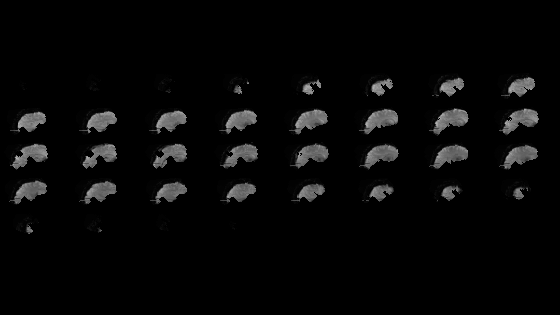
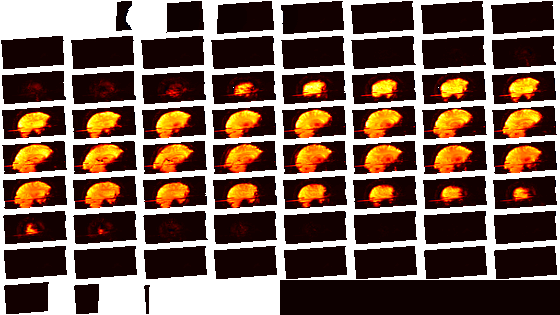

In [41]:
plotting.view_img(bold_mean, bg_img=bold_mean)

* __Resample image to a template__<br>
Using resample_to_img, we can resample one image to have the same dimensions as another one. For example, let's resample an anatomical T1 image to the computed mean image above.

In [44]:
print("Before Resampling", [bold_mean.shape, t1.shape])
resampled_t1 = image.resample_to_img(t1, bold_mean)
print("After Resampling", [bold_mean.shape, resampled_t1.shape])

Before Resampling [(64, 64, 30), (256, 156, 256)]
After Resampling [(64, 64, 30), (64, 64, 30)]


Now, we will have a look at `resampled_t1` image to see if the image has not changed uncorrectly.

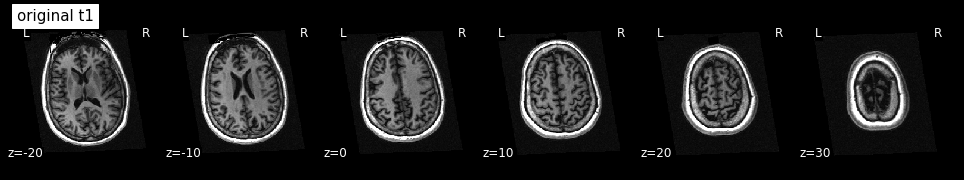

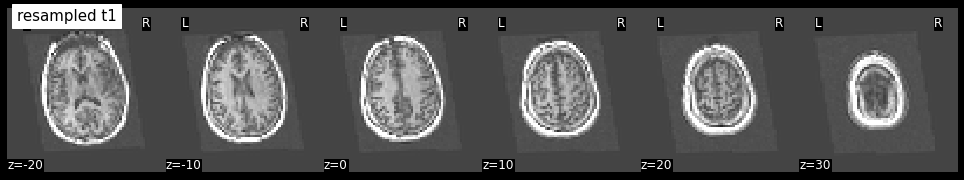

In [54]:
plotting.plot_anat(t1, title='original t1', display_mode='z', dim=-1,
                   cut_coords=[-20, -10, 0, 10, 20, 30])
plotting.plot_anat(resampled_t1, title='resampled t1', display_mode='z', dim=-1,
                   cut_coords=[-20, -10, 0, 10, 20, 30])

* __Smooth an image__<br>
Using `smooth_img`, we can very quickly smooth any kind of MRI image. Let's, for example, take the mean image from above and smooth it with different FWHM values.

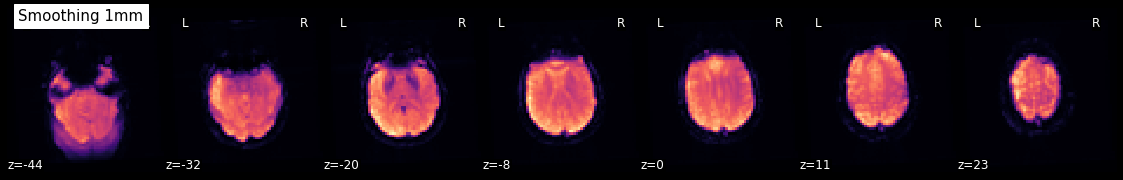

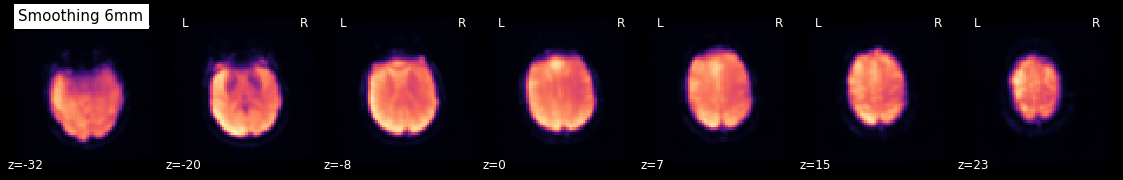

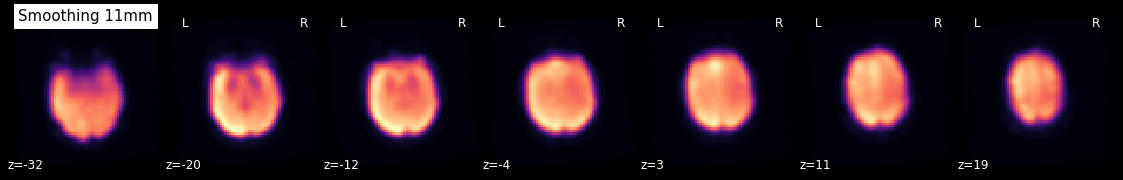

In [55]:
for fwhm in range(1, 12, 5):
    smoothed_img = image.smooth_img(bold_mean, fwhm)
    plotting.plot_epi(smoothed_img, title="Smoothing %imm" % fwhm,
                     display_mode='z', cmap='magma')

## 2. Data Visualization with NiLearn

In [56]:
import nilearn as nl
from nilearn import image
from nilearn import plotting, datasets, surface
from matplotlib import pyplot as plt

* __Overlay functional image onto anatomical image__ <br>

In [81]:
mask_dir = "/home/mohammad/Programs/Educational/ADHD_Figs/Brain_Figs/NeuralCorrelates_masks/fALFF.nii.gz"
overlay = image.load_img(mask_dir)

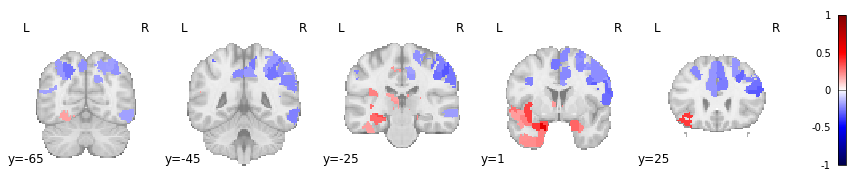

In [85]:
plotting.plot_stat_map(overlay, draw_cross=False, display_mode='y',
                           cut_coords=[-65, -45, -25, 1, 25],
                           threshold=0.01, colorbar=True, cmap='seismic', vmax=1)
plotting.show()

* __3D Surface Plot__

In [79]:
mask_dir = "/home/mohammad/Programs/Educational/ADHD_Figs/Brain_Figs/NeuralCorrelates_masks/fALFF.nii.gz"
overlay = image.load_img(mask_dir)

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage5')
hemisphere = "left"
surf = fsaverage['pial_' + hemisphere]
bg_surf = fsaverage['sulc_'+hemisphere]
texture = surface.vol_to_surf(overlay, surf)

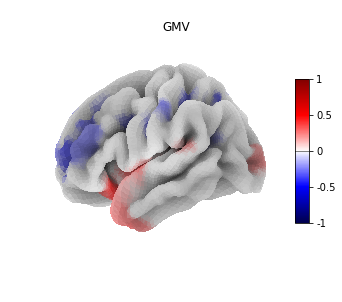

In [80]:
plotting.plot_surf_stat_map(surf, texture, cmap='seismic', view='lateral',
                            threshold=0.01, bg_map=bg_surf, hemi=hemisphere,
                            bg_on_data=True, title="GMV", vmax = 1)
plotting.show()

---
# fslpy
[Reference](https://git.fmrib.ox.ac.uk/fsl/fslpy/-/blob/master/README.rst) <br>

The `fslpy` package is a collection of utilities and data abstractions used within FSL and by FSLeyes. So, you can only use this package with `FSL` __installed__ on your device.

* Installation

```python
!pip install fslpy
```

The top-level Python package for fslpy is called fsl. here we will work with `fsl.wrappers` sub-package ([Reference](https://open.win.ox.ac.uk/pages/fsl/fslpy/fsl.wrappers.html)). this sub-package supports most functions of `FSL` for preprocessing such as `BET`, `flirt`, `fnirt`, `fslmaths`. `fslstats`, `fast`, `melodic`, `tbss` and so on. OK, let's import this sub-package:

In [2]:
import fsl.wrappers as fsl

Now, for example we will threshold a structural image with `fslmaths` function. First, let's have a look at data; for visualization we will use `nilearn`:

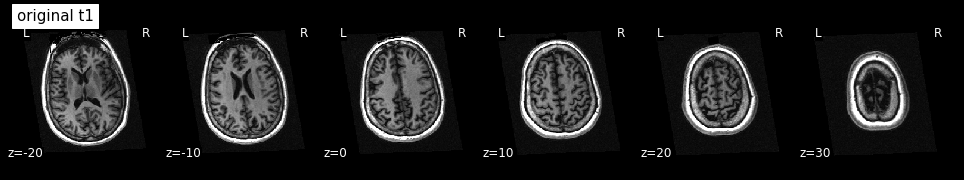

In [4]:
from nilearn import image
from nilearn import plotting

t1 = image.load_img("data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz")
plotting.plot_anat(t1, title='original t1', display_mode='z', dim=-1,
                   cut_coords=[-20, -10, 0, 10, 20, 30])
plotting.show()

Second, we will have regions where has value between 100-200:

In [14]:
fsl.fslmaths(t1).thr(570).uthr(800).run("data/thresholded_t1.nii.gz")

{}

finally, we load and visualize thresholded image with nilearn:

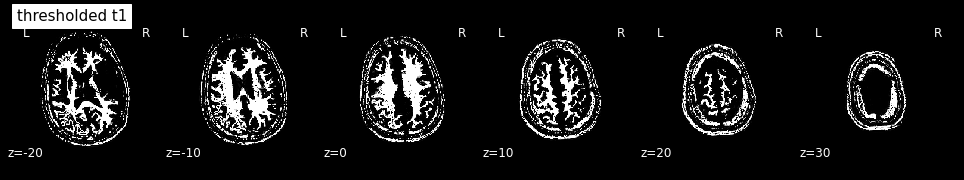

In [15]:
t1_thresh = image.load_img("data/thresholded_t1.nii.gz")
plotting.plot_anat(t1_thresh, title='thresholded t1', display_mode='z', dim=-1,
                   cut_coords=[-20, -10, 0, 10, 20, 30])
plotting.show()

* __BET__
we can use bet function from `fsl.wrappers`.

__Parameters__
>mask – Generate a brain mask <br>
seg – If False, a brain extracted image is not generated.<br>
robust – Robust brain centre estimation<br>
fracintensity – Fractional intensity threshold

In [31]:
fsl.bet(t1, "data/brain.nii.gz", fracintensity=0.2)

{}

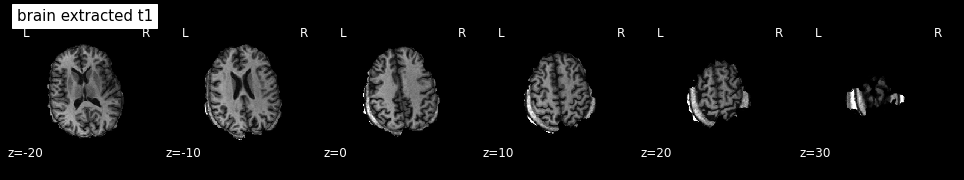

In [32]:
t1_brain = image.load_img("data/brain.nii.gz")
plotting.plot_anat(t1_brain, title='brain extracted t1', display_mode='z', dim=-1,
                   cut_coords=[-20, -10, 0, 10, 20, 30])
plotting.show()

if we want to mask an image, we can do it as it is in FSL command palette:

In [ ]:
fsl.fslmaths(img).mas(mask).run('data/masked_img.nii.gz')